With PCA as dimension reduction method, we are hoping that the signals of bankruptcy are concentrated in the first few PC, and we can use fewer predictors for our classification problem. 

The number of principal components M can be tuned in model training for better validation results. As an initial preprocessing step, 6 principal components were selected based on the elbow method.

Note: As outliers were removed, some comments on size of dataset are not accurate anymore, but they are still kept here

Number of variables have changed from:
96 (original) -> 29 (after feature selection) -> 6 (after PCA)

Number of observations have changed from:
* training set 4042 -> 6698 (after ADASYN sampling)
* validation set 673 UNCHANGED
* testing set 2023 UNCHANGED 

In [ ]:
# Upload data to session storage before proceeding
df = read.csv("data.csv")

In [ ]:
# check correct dimensions
dim(df)

[1] 6819   96

# Creating Dictionary
key = Y or X_, value = Bankrupt. or predictor name

In [ ]:
install.packages("hash")
library(hash)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

hash-2.2.6.2 provided by Decision Patterns




In [ ]:
# create dictionary for dataset column names and shortforms
column_names <- hash()
key = 1
for (word in colnames(df)) {
  if (word == "Bankrupt.") {
    column_names["Y"] = list()
    column_names["Y"] = append(column_names[["Y"]], word)
    next;
  }
  else {
    column_names[paste0("X", key)] = list()
    column_names[paste0("X", key)] = append(column_names[[paste0("X", key)]], word)
    key = key + 1
  }
}

In [ ]:
column_names[["Y"]]

[[1]]
[1] "Bankrupt."

# Splitting Data and Sampling
including outlier removal

In [ ]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
# changing colnames
colnames(df) <- c("Y", paste("X", c(1:95), sep = ""))

# changing Y col to a factor
df$Y <- as.factor(df$Y)

In [ ]:
## outliers flagged from isolation forest
outliers = c(57,  380,  428, 1036, 1428, 1430, 1441, 1444, 1521, 1625, 1641,

       1685, 1754, 1756, 1847, 1862, 1866, 1870, 1871, 1952, 1968, 2002,

       2005, 2006, 2100, 2174, 2199, 2296, 2362, 2365, 2366, 2394, 2436,

       2441, 2471, 2491, 2497, 2594, 2606, 2641, 2723, 2736, 2771, 2931,

       3147, 3170, 3208, 3225, 3393, 3541, 3596, 3623, 3683, 3696, 3843,

       3846, 3848, 3907, 3909, 3932, 4117, 4228, 4296, 4328, 4339, 4438,

       4448, 4450, 4779, 4825, 4876, 4878, 4919, 5026, 5034, 5164, 6019,

       6611, 6614, 6642, 6643)

df = df[-outliers, ]

In [ ]:
dim(df)

[1] 6738   96

In [ ]:
set.seed(4248)

# randomly shuffle the rows
rows <- 1:nrow(df)
shuffled_rows <- sample(rows)

# no. of rows for each split
train <- floor(0.6 * length(shuffled_rows)) #4091
val <- floor(0.1 * length(shuffled_rows)) #681
test <- length(shuffled_rows) - train - val #2047

# split into train, validation, and test sets
train_no <- shuffled_rows[1:train]
val_no <- shuffled_rows[(train + 1):(train + val)]
test_no <- shuffled_rows[(train + val + 1):length(shuffled_rows)]

train_set <- df[train_no, ]
val_set <- df[val_no, ] 
test_set <- df[test_no, ] 

In [ ]:
print(dim(train_set))
print(dim(val_set))
print(dim(test_set))

[1] 4042   96
[1] 673  96
[1] 2023   96


In [ ]:
install.packages('themis')
library('themis')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘lava’, ‘prodlim’, ‘clock’, ‘ipred’, ‘timeDate’, ‘recipes’, ‘gower’, ‘RANN’, ‘ROSE’, ‘hardhat’


Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The following object is masked from ‘package:stats’:

    step




In [ ]:
# ADASYN
adasyn_data <- adasyn(train_set, "Y", over_ratio=0.7)
table(adasyn_data$Y) # 3966 2776
table(train_set$Y) # original 3966 125
2776/(2776 +3966) #0.41


   0    1 
3940 2758 


   0    1 
3940  102 

[1] 0.4117473

In [ ]:
table(adasyn_data$Y)
table(train_set$Y)
2758/(2758+3940)


   0    1 
3940 2758 


   0    1 
3940  102 

[1] 0.4117647

In [ ]:
dim(adasyn_data)

[1] 6698   96

train_set - data for training

adasyn_data - minority oversampled data for training

val_set - data for validation

test_set - data for testing

# Feature Selection

In [ ]:
install.packages("glmnet")
library(glmnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-6



In [ ]:
x<-model.matrix(Y~., adasyn_data )[,-1]
y<-adasyn_data[,1]
set.seed(1)
grid<-10^seq(10, -2, length=100)

In [ ]:
cv.out <- cv.glmnet(x, y, alpha = 1, family = "binomial")
bestlam <- cv.out$lambda.min
out <- glmnet(x, y, alpha =1, lambda=grid, family = "binomial")
lasso.coef <- predict(out, type = "coefficient", s=bestlam)[1:96]
which(lasso.coef!=0)
#variables after feature selection:
# 1  2 13 20 28 37 38 39 44 46 47 49 50 52 58 61 72 75 81 85 87 93

[1]  1  4 12 16 20 27 35 36 37 38 39 41 45 47 49 50 51 52 53 58 61 69 73 75 82
[26] 83 87 93

In [ ]:
which(lasso.coef!=0)

[1]  1  4 12 16 20 27 35 36 37 38 39 41 45 47 49 50 51 52 53 58 61 69 73 75 82
[26] 83 87 93

Final variables selected from LASSO

In [ ]:
subset = c()
for (ele in which(lasso.coef!=0)) {
  subset = c(subset, paste0("X", ele))
}

In [ ]:
subset = c(subset, "Y")

In [ ]:
print(subset)

 [1] "X1"  "X4"  "X12" "X16" "X20" "X27" "X35" "X36" "X37" "X38" "X39" "X41"
[13] "X45" "X47" "X49" "X50" "X51" "X52" "X53" "X58" "X61" "X69" "X73" "X75"
[25] "X82" "X83" "X87" "X93" "Y"  


In [ ]:
dim(adasyn_data)

[1] 6698   96

In [ ]:
## Removal of X95 which has sd = 0 not necessary since it wasn't selected in LASSO
## Extracting the subset of predictors for training, validation and testing sets

adasyn_data = adasyn_data %>% select(c(subset))
train_set = train_set %>% select(c(subset))
val_set = val_set %>% select(c(subset))
test_set = test_set %>% select(c(subset))

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(subset)

  # Now:
  data %>% select(all_of(subset))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


In [ ]:
print(dim(adasyn_data))
print(dim(val_set))
print(dim(test_set))

[1] 6698   29
[1] 673  29
[1] 2023   29


28 variables + 1 response set:
* train_set - data for training

* adasyn_data - minority oversampled data for training

* val_set - data for validation

* test_set - data for testing

# Dimension Reduction with PCA

In [ ]:
training_x = adasyn_data %>% select(-"Y")
training_y = adasyn_data %>% select("Y")

In [ ]:
colnames(training_x)
colnames(training_y)

[1] "X1"  "X4"  "X12" "X16" "X20" "X27" "X35" "X36" "X37" "X38" "X39" "X41"
[13] "X45" "X47" "X49" "X50" "X51" "X52" "X53" "X58" "X61" "X69" "X73" "X75"
[25] "X82" "X83" "X87" "X93"

[1] "Y"

In [ ]:
options(scipen = 100)
data.frame(apply(training_x, 2, mean)) # some variables have very large scale

,apply.training_x..2..mean.
,<dbl>
X1,0.479119018
X4,0.604944875
X12,1693833208.681266069
X16,0.180228011
X20,0.320850917
X27,0.689036921
X35,0.630245778
X36,10757414.726010077
X37,0.138938626


In [ ]:
data.frame(apply(training_x, 2, var)) # expected that the same vars have larger variance

,apply.training_x..2..var.
,<dbl>
X1,0.003775400178
X4,0.000138809999
X12,5852657904226684928.000000000000
X16,0.000808816323
X20,0.000154016079
X27,0.000097504636
X35,0.000091652787
X36,39648727931798016.000000000000
X37,0.003620051694


In [ ]:
# center variables to mean 0 and scale to sd 1
pr.out = prcomp(training_x, scale = T, retx = T)

In [ ]:
pr.out$rotation^2 %>% apply(2, sum) # check

# For the rotation matrix below, PC1 = -0.379X1 + -0.296X4 + ..., the square of coefs add up to 1
# tells us how to get PCs from various predictor variables

PC1  PC2  PC3  PC4  PC5  PC6  PC7  PC8  PC9 PC10 PC11 PC12 PC13 PC14 PC15 PC16 
   1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1 
PC17 PC18 PC19 PC20 PC21 PC22 PC23 PC24 PC25 PC26 PC27 PC28 
   1    1    1    1    1    1    1    1    1    1    1    1

In [ ]:
pr.out$rotation # Each PC is a linear combination of 28 variables, the coefficient is as shown in each entry below.

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
X1,-0.379347296,0.112897881,-0.0002756565,0.10700917,-0.127026584,0.032050009,-0.037951532,0.10921013,0.0229645094,0.0203322848,⋯,0.228222571,-0.0597367358,-0.179292511,0.4527486885,0.0614262177,-0.580838095,0.2205428300,-0.06403424282,-0.0042787579,-0.000000000000000258344828
X4,-0.296833187,-0.047381264,-0.0061632182,0.11701838,-0.009391422,0.049074259,-0.209565137,0.12323993,0.1817066701,-0.0589428502,⋯,-0.290407450,0.2083934210,0.404641693,-0.2859965188,-0.0735013430,-0.036281811,-0.0728522284,-0.01136134593,0.0029055403,-0.000000000000000501801714
X12,-0.071263689,-0.029651588,0.0352757576,-0.08536303,-0.143468517,0.048358059,-0.269071330,-0.42315379,0.1637471354,0.1518509552,⋯,-0.111965623,0.0400666298,-0.007111246,0.0006949702,-0.0027930520,-0.048156573,0.0267589392,-0.01453417613,-0.0017894501,-0.000000000000000010959768
X16,-0.318916552,0.082144670,-0.0106875233,0.19310271,-0.190520128,0.045570413,0.054284889,0.08320257,-0.0670989348,0.0828382845,⋯,0.659595677,0.0529745545,0.248138578,-0.1813518625,-0.2149189756,0.337887367,-0.0747686319,0.11650759184,0.0012123819,0.000000000000000218536029
X20,-0.299907300,0.127351798,0.0452475693,-0.31964621,0.190350161,-0.089064906,-0.197986504,0.12897793,-0.1697260858,0.0497929244,⋯,0.099067782,0.0215037874,0.081154372,-0.3072396962,0.4327826702,-0.049911135,0.1173538792,-0.48659669453,0.0084414117,0.000000000000000073914925
X27,-0.029225642,0.041103148,-0.0053921252,0.06591588,-0.081288035,0.042832475,0.026116949,0.06832587,0.4197124718,0.0107639895,⋯,-0.051092247,0.0171647583,0.027162230,-0.0428583335,-0.0084895893,0.019161157,-0.0026146845,0.00668210190,0.0001377030,-0.000000000000000132575408
X35,-0.036140134,0.035572825,0.0048266590,-0.01684632,-0.085283170,0.078764272,0.052779830,-0.13150999,-0.0091327833,0.7137058173,⋯,0.014083879,0.0129925925,0.027246311,0.0074057458,-0.0075888246,-0.014760857,-0.0007533235,-0.00446365422,-0.0005558952,0.000000000000000250717865
X36,-0.050394429,-0.072520000,-0.0075684204,-0.13049123,0.256653908,-0.206883355,0.630153115,-0.22812533,0.2149287454,-0.0204405623,⋯,0.221254721,0.0254885688,0.030268601,-0.2222839235,0.3374629554,-0.159885485,-0.0646252196,0.14061714160,-0.0078337816,-0.000000000000000090715921
X37,0.371405955,0.203400342,0.0105772119,-0.17309064,0.177916731,-0.019676427,-0.148412310,0.21507423,0.0304412143,0.0852750838,⋯,0.251478271,0.0194507477,0.051781300,0.0620592644,-0.0930043297,-0.059094641,-0.1100084089,-0.05950233504,-0.0036896113,0.707106781186547239670404
X38,-0.371405955,-0.203400342,-0.0105772119,0.17309064,-0.177916731,0.019676427,0.148412310,-0.21507423,-0.0304412143,-0.0852750838,⋯,-0.251478271,-0.0194507477,-0.051781300,-0.0620592644,0.0930043297,0.059094641,0.1100084089,0.05950233504,0.0036896113,0.707106781186547572737311


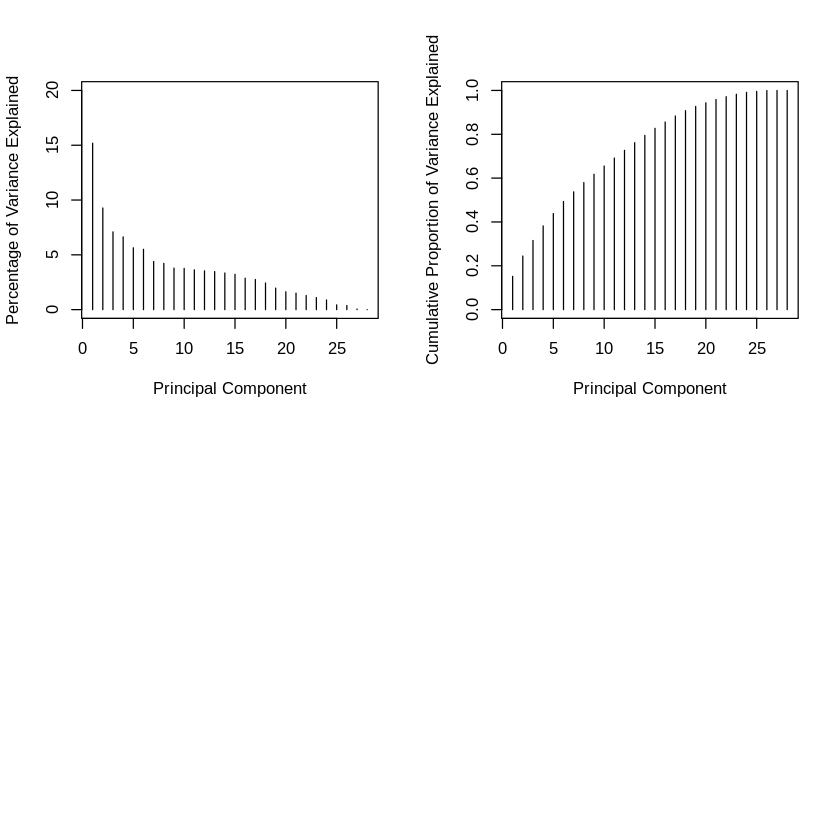

In [ ]:
## Elbow of Scree Plot seems to be at the 6th principal component. 

pr.var = pr.out$sdev^2
pve = pr.var/sum(pr.var)

par(mfrow=c(2,2))
plot(100*pve, xlab="Principal Component", ylab="Percentage of Variance Explained", ylim=c(0,20),type='h')

plot(cumsum(pve), xlab="Principal Component", ylab="Cumulative Proportion of Variance Explained", ylim=c(0,1),type='h')

In [ ]:
dim(pr.out$x) 
# is a matrix of our training obs being centred, scaled, and then multiplied by rotation matrix. 

[1] 6698   28

In [ ]:
head(pr.out$x) # PC values for first 6 training observations 

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0.08173134,-0.6611753,0.10922943,0.06741956,0.3122676,0.09642304,0.4357013,1.10174846,-0.3687363,0.41747280,⋯,-0.4630826,-0.05532071,-0.22619572,0.10928915,0.148525945,-0.28916194,0.04231303,0.06930758,-0.006053864,0.0000000000000006909241
-4.33964346,-0.1122683,0.13807477,-0.29947995,-0.2598009,-0.18474522,-0.4701815,-1.08110880,0.3686873,0.04942822,⋯,-0.7984724,-0.06358911,-0.40133832,0.61960163,-0.465057878,-0.04164068,0.23784117,-0.14416750,0.037781502,0.0000000000000056918669
1.00910685,0.7254249,-0.02634203,0.09317345,-0.5924235,0.42738675,-0.3385680,-0.50197973,0.7390327,0.14374277,⋯,0.1988045,-0.08253509,-0.09189055,0.19438630,-0.007992342,-0.05508618,-0.02117213,-0.16862419,0.001426945,0.0000000000000006794579
-3.10609282,-0.8154083,0.06119058,0.89988989,-0.5548486,0.22165872,-0.3619988,0.83150899,0.0506611,-0.14233333,⋯,1.5301154,0.13445009,0.52229868,0.10974167,-0.062648483,-0.61271217,0.48381318,0.11514619,0.007088417,-0.0000000000000013404656
-1.07227363,-2.4762024,0.18976164,0.83666066,-0.7189558,0.34818854,0.7711765,-0.45611861,0.3834989,0.48527887,⋯,-0.6364227,-0.17605334,-0.30319383,-0.13418182,0.352061384,0.37219471,0.40661735,0.25589702,-0.003801754,0.0000000000000040792637
-2.22046305,0.0896748,0.09535941,-0.47111169,0.1249684,-0.24039836,-0.3206523,-0.00648672,-0.2979374,-0.10527478,⋯,0.4124654,-0.08417801,-0.13125936,0.05169083,0.046439346,-0.04912729,0.02591947,0.22489199,-0.006519826,-0.0000000000000032546518


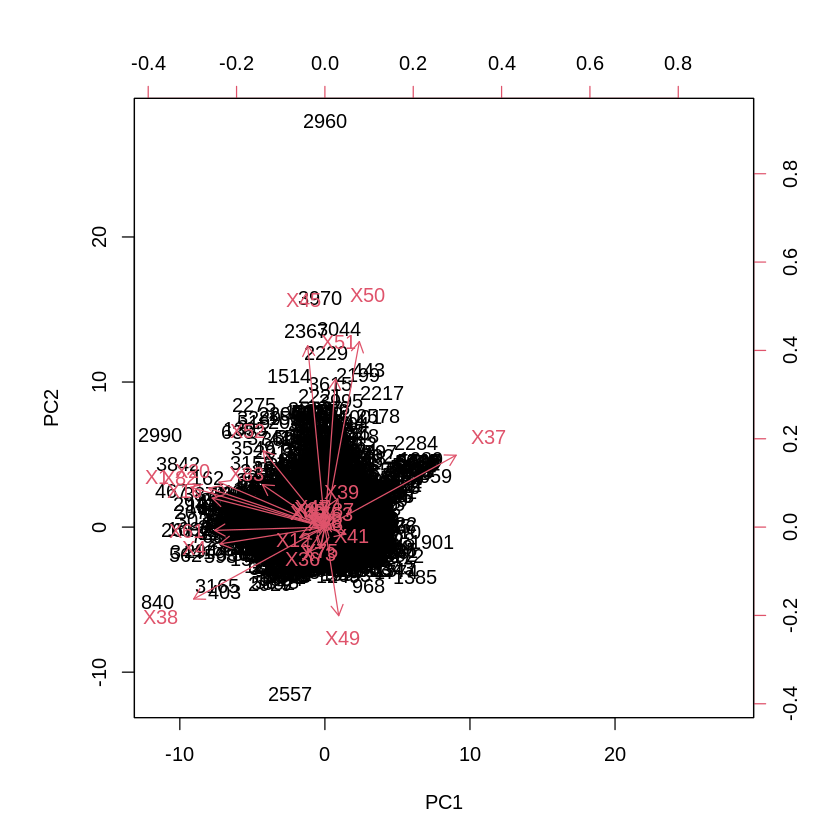

In [ ]:
biplot(pr.out, scale = 0)

# X37 is one of the most important variables for PC 1
# X45 and X50 are the most important variables for PC 2

In [ ]:
# verified: X37 is one of the most important variables for PC 1
data.frame(pr.out$rotation) %>% select("PC1") %>% arrange(-abs(PC1)) %>% head()
column_names[["X1"]]

# verified: X45 and X50 are the most important variables for PC 2
data.frame(pr.out$rotation) %>% select("PC2") %>% arrange(-abs(PC2)) %>% head()
column_names[["X45"]]
column_names[["X50"]]

,PC1
,<dbl>
X1,-0.3793473
X37,0.3714060
X38,-0.3714060
X82,-0.3290320
X16,-0.3189166
X61,-0.3122924


[[1]]
[1] "ROA.C..before.interest.and.depreciation.before.interest"

,PC2
,<dbl>
X50,0.5249669
X45,0.5135552
X51,0.4187868
X49,-0.2505789
X52,0.2164932
X37,0.2034003


[[1]]
[1] "Total.Asset.Turnover"

[[1]]
[1] "Net.Worth.Turnover.Rate..times."

Transforming dataset into PC-predictors

In [ ]:
# can ignore, for familiarising with matrix multiplication syntax
v1 = c(1,2)
v2 = c(3,4)
v3 = c(2,4)
v4 = c(6,0)
matrix(rbind(v1, v2), nrow = 2)%*%matrix(rbind(v3, v4), nrow = 2)

14,4
30,12


In [ ]:
data.matrix(scale(training_x, scale = T)) %>% head()
data.matrix(scale(training_x, scale = T)) %>% dim()

data.matrix(pr.out$rotation) %>% head()
data.matrix(pr.out$rotation) %>% dim()

X1,X4,X12,X16,X20,X27,X35,X36,X37,X38,⋯,X53,X58,X61,X69,X73,X75,X82,X83,X87,X93
0.2505791,-0.16450858,-0.70015480,-0.3274413,0.003594193,0.11206891,0.22686769,-0.05402481,-0.03400411,0.03400411,⋯,-0.0573355,-0.01221877,-0.1158682,-0.008453914,-0.028130325,-0.012881918,0.09898941,-0.01130564,-0.06785733,0.14187723
1.6897972,1.18059839,2.30907122,0.6223256,0.867114079,0.04104518,0.04164234,-0.05402481,-1.68715463,1.68715463,⋯,-0.0573355,-0.01221877,2.0907207,0.012046988,-0.009149673,-0.007563594,1.46699567,0.64855082,-0.06785733,-0.03477127
0.2386782,0.33096057,0.77965690,-0.1985338,-0.674682153,0.05237110,0.13218026,-0.05402481,0.71317973,-0.71317973,⋯,-0.0573355,-0.01221877,-0.4110252,-0.013165275,-0.017247776,-0.014713241,-0.75902673,-0.62834721,-0.06785733,0.06029966
2.3205460,1.64487133,-0.70015480,2.0121561,0.639122030,0.03883610,0.03827981,-0.05402481,-0.86711158,0.86711158,⋯,-0.0573355,-0.01221877,0.1805966,0.057927671,-0.011810446,-0.013749073,0.43618031,-0.05496909,-0.06785733,-0.03808938
-0.0786797,-0.30213889,0.23402800,0.3941445,-0.244347160,0.02017578,0.03953182,-0.05402481,-2.06451513,2.06451513,⋯,-0.0573355,-0.01221877,-0.1626814,0.002575218,-0.014620707,-0.046070395,-0.28635369,-1.60693307,-0.06785733,-0.03585786
0.6702849,-0.03177178,0.06455236,0.7408613,1.092256227,0.03028613,0.05026330,-0.05402481,-0.74752197,0.74752197,⋯,-0.0573355,-0.01221877,0.6366943,0.007882861,-0.009613107,-0.007568179,1.30753688,0.68550410,-0.06785733,-0.02515779


[1] 6698   28

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
X1,-0.37934730,0.11289788,-0.0002756565,0.10700917,-0.127026584,0.03205001,-0.03795153,0.10921013,0.02296451,0.02033228,⋯,0.22822257,-0.05973674,-0.179292511,0.4527486885,0.061426218,-0.58083809,0.220542830,-0.064034243,-0.004278758,-0.00000000000000025834483
X4,-0.29683319,-0.04738126,-0.0061632182,0.11701838,-0.009391422,0.04907426,-0.20956514,0.12323993,0.18170667,-0.05894285,⋯,-0.29040745,0.20839342,0.404641693,-0.2859965188,-0.073501343,-0.03628181,-0.072852228,-0.011361346,0.002905540,-0.00000000000000050180171
X12,-0.07126369,-0.02965159,0.0352757576,-0.08536303,-0.143468517,0.04835806,-0.26907133,-0.42315379,0.16374714,0.15185096,⋯,-0.11196562,0.04006663,-0.007111246,0.0006949702,-0.002793052,-0.04815657,0.026758939,-0.014534176,-0.001789450,-0.00000000000000001095977
X16,-0.31891655,0.08214467,-0.0106875233,0.19310271,-0.190520128,0.04557041,0.05428489,0.08320257,-0.06709893,0.08283828,⋯,0.65959568,0.05297455,0.248138578,-0.1813518625,-0.214918976,0.33788737,-0.074768632,0.116507592,0.001212382,0.00000000000000021853603
X20,-0.29990730,0.12735180,0.0452475693,-0.31964621,0.190350161,-0.08906491,-0.19798650,0.12897793,-0.16972609,0.04979292,⋯,0.09906778,0.02150379,0.081154372,-0.3072396962,0.432782670,-0.04991113,0.117353879,-0.486596695,0.008441412,0.00000000000000007391492
X27,-0.02922564,0.04110315,-0.0053921252,0.06591588,-0.081288035,0.04283247,0.02611695,0.06832587,0.41971247,0.01076399,⋯,-0.05109225,0.01716476,0.027162230,-0.0428583335,-0.008489589,0.01916116,-0.002614684,0.006682102,0.000137703,-0.00000000000000013257541


[1] 28 28

In [ ]:
scale(training_x, scale = T)%*%pr.out$rotation %>% head()

pr.out$x %>% head() # verified with above: pr.out$x IS our newly transformed predictor-observations

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0.08173134,-0.6611753,0.10922943,0.06741956,0.3122676,0.09642304,0.4357013,1.10174846,-0.3687363,0.41747280,⋯,-0.4630826,-0.05532071,-0.22619572,0.10928915,0.148525945,-0.28916194,0.04231303,0.06930758,-0.006053864,0.0000000000000006909241
-4.33964346,-0.1122683,0.13807477,-0.29947995,-0.2598009,-0.18474522,-0.4701815,-1.08110880,0.3686873,0.04942822,⋯,-0.7984724,-0.06358911,-0.40133832,0.61960163,-0.465057878,-0.04164068,0.23784117,-0.14416750,0.037781502,0.0000000000000056918669
1.00910685,0.7254249,-0.02634203,0.09317345,-0.5924235,0.42738675,-0.3385680,-0.50197973,0.7390327,0.14374277,⋯,0.1988045,-0.08253509,-0.09189055,0.19438630,-0.007992342,-0.05508618,-0.02117213,-0.16862419,0.001426945,0.0000000000000006794579
-3.10609282,-0.8154083,0.06119058,0.89988989,-0.5548486,0.22165872,-0.3619988,0.83150899,0.0506611,-0.14233333,⋯,1.5301154,0.13445009,0.52229868,0.10974167,-0.062648483,-0.61271217,0.48381318,0.11514619,0.007088417,-0.0000000000000013404656
-1.07227363,-2.4762024,0.18976164,0.83666066,-0.7189558,0.34818854,0.7711765,-0.45611861,0.3834989,0.48527887,⋯,-0.6364227,-0.17605334,-0.30319383,-0.13418182,0.352061384,0.37219471,0.40661735,0.25589702,-0.003801754,0.0000000000000040792637
-2.22046305,0.0896748,0.09535941,-0.47111169,0.1249684,-0.24039836,-0.3206523,-0.00648672,-0.2979374,-0.10527478,⋯,0.4124654,-0.08417801,-0.13125936,0.05169083,0.046439346,-0.04912729,0.02591947,0.22489199,-0.006519826,-0.0000000000000032546518


PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0.08173134,-0.6611753,0.10922943,0.06741956,0.3122676,0.09642304,0.4357013,1.10174846,-0.3687363,0.41747280,⋯,-0.4630826,-0.05532071,-0.22619572,0.10928915,0.148525945,-0.28916194,0.04231303,0.06930758,-0.006053864,0.0000000000000006909241
-4.33964346,-0.1122683,0.13807477,-0.29947995,-0.2598009,-0.18474522,-0.4701815,-1.08110880,0.3686873,0.04942822,⋯,-0.7984724,-0.06358911,-0.40133832,0.61960163,-0.465057878,-0.04164068,0.23784117,-0.14416750,0.037781502,0.0000000000000056918669
1.00910685,0.7254249,-0.02634203,0.09317345,-0.5924235,0.42738675,-0.3385680,-0.50197973,0.7390327,0.14374277,⋯,0.1988045,-0.08253509,-0.09189055,0.19438630,-0.007992342,-0.05508618,-0.02117213,-0.16862419,0.001426945,0.0000000000000006794579
-3.10609282,-0.8154083,0.06119058,0.89988989,-0.5548486,0.22165872,-0.3619988,0.83150899,0.0506611,-0.14233333,⋯,1.5301154,0.13445009,0.52229868,0.10974167,-0.062648483,-0.61271217,0.48381318,0.11514619,0.007088417,-0.0000000000000013404656
-1.07227363,-2.4762024,0.18976164,0.83666066,-0.7189558,0.34818854,0.7711765,-0.45611861,0.3834989,0.48527887,⋯,-0.6364227,-0.17605334,-0.30319383,-0.13418182,0.352061384,0.37219471,0.40661735,0.25589702,-0.003801754,0.0000000000000040792637
-2.22046305,0.0896748,0.09535941,-0.47111169,0.1249684,-0.24039836,-0.3206523,-0.00648672,-0.2979374,-0.10527478,⋯,0.4124654,-0.08417801,-0.13125936,0.05169083,0.046439346,-0.04912729,0.02591947,0.22489199,-0.006519826,-0.0000000000000032546518


In [ ]:
# Split data into predictor and response data

## done for training above

## validation
validation_x = val_set %>% select(-"Y")
val_y = val_set %>% select("Y")

## testing
testing_x = test_set %>% select(-"Y")
test_y = test_set %>% select("Y")

In [ ]:
## Extract 6 PCs
pcomps_transform = pr.out$rotation[, 1:6]

In [ ]:
## Transform predictor data for training data, validation data, testing data

train_x = pr.out$x[, 1:6]
val_x = scale(validation_x, scale = T)%*%pcomps_transform
test_x = scale(testing_x, scale = T)%*%pcomps_transform

In [ ]:
dim(train_x)
dim(val_x)
dim(test_x)

[1] 6698    6

[1] 673   6

[1] 2023    6

In [ ]:
training_y %>% dim()
val_y %>% dim()
test_y %>% dim()

[1] 6698    1

[1] 673   1

[1] 2023    1

Join back predictor and respones data

In [ ]:
trng_dat = cbind(train_x, training_y)
vali_dat = cbind(val_x, val_y)
test_dat = cbind(test_x, test_y)

In [ ]:
trng_dat %>% head(n=2)
vali_dat %>% head(n=2)
test_dat %>% head(n=2)

,PC1,PC2,PC3,PC4,PC5,PC6,Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.08173134,-0.6611753,0.1092294,0.06741956,0.3122676,0.09642304,0
2,-4.33964346,-0.1122683,0.1380748,-0.29947995,-0.2598009,-0.18474522,0


,PC1,PC2,PC3,PC4,PC5,PC6,Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1900,0.7111124,0.0891737,-0.003438257,0.6754689,-0.1742999,0.1823955,0
1112,0.1897990,-1.1794170,-0.279716491,0.7644481,-0.7414366,0.3697875,0


,PC1,PC2,PC3,PC4,PC5,PC6,Y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1944,1.132612,-0.4898991,0.1351815,-0.2524224,-0.9912458,0.30949056,0
166,1.294689,0.6317405,-0.1073568,0.6294434,-0.5653419,-0.05972052,0


In [ ]:
trng_dat %>% dim()
vali_dat %>% dim()
test_dat %>% dim()

[1] 6698    7

[1] 673   7

[1] 2023    7

Export pre-processed data (dataframes) to CSV

In [ ]:
write.csv(trng_dat, "trng_dat.csv", row.names=F)

In [ ]:
write.csv(vali_dat, "vali_dat.csv", row.names=F)

In [ ]:
write.csv(test_dat, "test_dat.csv", row.names=F)